In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
from operator import itemgetter

In [2]:
ratings = pd.read_csv('/home/alainkuiete/Documents/DATA612/rating.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [3]:
ratings.userId = [str(n)+'U' for n in ratings.userId]
ratings.movieId = [str(n)+'M' for n in ratings.movieId]

In [4]:
ratings.shape

(20000263, 4)

In [5]:
rating = ratings.iloc[:10000, :]

## Create a bipartite graph

### Add weighted edges between opposite nodes

In [6]:
G = nx.Graph()

In [7]:
edges = rating[['userId', 'movieId', 'rating']]

In [8]:
edgelist = np.array(edges)

In [9]:
G.add_weighted_edges_from(edgelist)

In [10]:
#G = nx.from_pandas_edgelist(rating, 'userId', 'movieId', 'rating')

In [11]:
nx.is_connected(G)

True

In [12]:
#G.edges(data=True)

### Add nodes with node attribute

In [13]:
G.add_nodes_from(set(rating.userId), bipartite = 0)
G.add_nodes_from(set(rating.movieId), bipartite = 1)

In [14]:
print(bipartite.is_bipartite(G))

True


In [15]:
#edglist = [(wiki.node1[wiki.index[n]], wiki.node2[wiki.index[n]]) for n in range(0, len(wiki.index))]

In [16]:
#B.add_edges_from(edglist)

### The two different subgraphs

In [17]:
user, movie = bipartite.sets(G)
print("Number of user nodes: ", len(user))
print("Number of movie nodes: ", len(movie))


Number of user nodes:  91
Number of movie nodes:  2889


In [18]:
user_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
movie_nodes = set(G) - user_nodes

In [19]:
#print(user)

In [20]:
bipartite.density(G, user)

0.03803742121499131

In [21]:
bipartite.density(G, movie)

0.03803742121499131

In [22]:
u = bipartite.projected_graph(G, user)
m = bipartite.projected_graph(G, movie)

In [23]:
#u.edges(data=True)

### Components with more than 5 connections

In [24]:
[len(c) for c in list(u.subgraph(b) for b in nx.connected_components(u)) if len(c) > 5]

[91]

## Island Method for the Bipartite Graph

In [25]:
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f, to, weight = edata)
    return g2

In [26]:
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

Number of nodes connected and number of subgraphs after each iteration. 
At each iteration the minimun number of neighbors for a node increases.

In [27]:
cc=list([G.subgraph(n) for n in nx.connected_components(G)])[0]
islands=island_method(cc)
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0], len(list(i[1])), len(list(G.subgraph(n) for n in nx.connected_components(i[1])))) 

0 2980 1
1 2902 1
2 2750 1
3 2270 1
4 1344 1


## Users Network

### Distribution of Degrees Centrality of the Network of Users

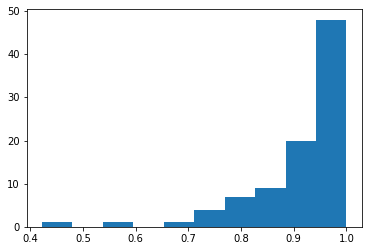

In [28]:
plt.hist(list(nx.degree_centrality(u).values()))
plt.show()

### Nodes with high degree centrality

In [29]:
def nodes_with_highest_deg_cent(h):
    deg_cent = nx.degree_centrality(h)
    max_dc = max(list(deg_cent.values()))
    nodes = set()
    for k,v in deg_cent.items():
        if v == max_dc:
            nodes.add(k)
    return nodes

In [30]:
top_dc = nodes_with_highest_deg_cent(u)

In [31]:
print(top_dc)

{'21U', '3U', '7U', '24U', '91U', '88U', '73U', '53U', '58U', '56U', '1U', '69U', '11U', '22U', '54U'}


### Nodes by Degree Centrality

In [32]:
deg_cent_u = nx.degree_centrality(u)

In [33]:
nx.set_node_attributes(u, deg_cent_u, 'degreecentrality')

In [34]:
sorted_deg_cent_u = sorted(deg_cent_u.items(), key=itemgetter(1), reverse=True)

In [35]:
print("Top 10 important users :")
for d in sorted_deg_cent_u[:10]:
    print(d,  nx.get_node_attributes(u, 'degreecentrality')[d[0]])

Top 10 important users :
('21U', 1.0) 1.0
('58U', 1.0) 1.0
('1U', 1.0) 1.0
('53U', 1.0) 1.0
('73U', 1.0) 1.0
('11U', 1.0) 1.0
('22U', 1.0) 1.0
('88U', 1.0) 1.0
('56U', 1.0) 1.0
('7U', 1.0) 1.0


In [36]:
len(list(nx.subgraph(u, u.neighbors('3U'))))

90

### Distribution of betweenness centrality

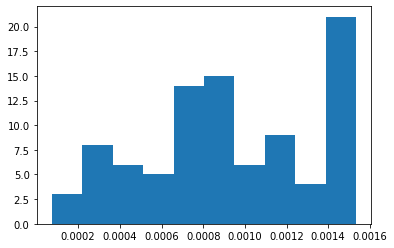

In [37]:
plt.hist(list(nx.betweenness_centrality(u).values()))
plt.show()

### Nodes with high betweeness centrality

In [38]:
def nodes_with_highest_bet_cent(h):
    deg_cent = nx.betweenness_centrality(h)
    max_dc = max(list(deg_cent.values()))
    nodes = set()
    for k,v in deg_cent.items():
        if v == max_dc:
            nodes.add(k)
    return nodes

In [39]:
top_bet = nodes_with_highest_bet_cent(u)

In [40]:
print(top_bet)

{'21U', '3U', '7U', '24U', '91U', '88U', '73U', '53U', '58U', '56U', '1U', '69U', '11U', '22U', '54U'}


### Eigenvector Centrality

In [41]:
eigen_cent = nx.eigenvector_centrality(u)

In [42]:
# Assign each to an attribute in your network
nx.set_node_attributes(u, eigen_cent, 'eigenvector')

In [43]:
sorted_eigenvector = sorted(eigen_cent.items(), key=itemgetter(1), reverse=True)

In [44]:
print("Top 10 influent users on the rating network:")
for e in sorted_eigenvector[:10]:
    print(e,  nx.get_node_attributes(u, 'eigenvector')[e[0]])

Top 10 influent users on the rating network:
('3U', 0.11246230729554349) 0.11246230729554349
('91U', 0.11246230729554349) 0.11246230729554349
('21U', 0.11246230729554348) 0.11246230729554348
('58U', 0.11246230729554348) 0.11246230729554348
('1U', 0.11246230729554348) 0.11246230729554348
('53U', 0.11246230729554348) 0.11246230729554348
('73U', 0.11246230729554348) 0.11246230729554348
('11U', 0.11246230729554348) 0.11246230729554348
('22U', 0.11246230729554348) 0.11246230729554348
('88U', 0.11246230729554348) 0.11246230729554348


### Users that are totaly connected

In [45]:
largest_clique = sorted(nx.find_cliques(u), key=lambda x:len(x))[-1]

In [46]:
largest_clique_u = sorted(nx.find_cliques(u), key=lambda x:len(x))[-1]

In [47]:
glcu = u.subgraph(largest_clique_u)

(-1.116564582589863,
 1.0937956031515408,
 -1.1034659148961798,
 1.0788245692493315)

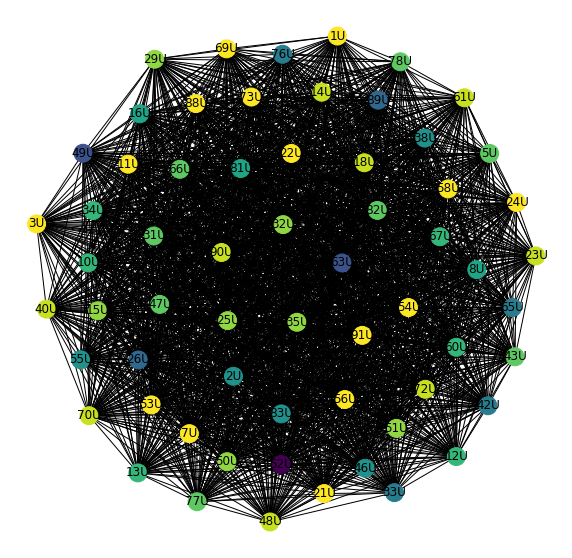

In [48]:
pos = nx.spring_layout(glcu)
betCent = nx.betweenness_centrality(glcu, normalized=True, endpoints=True)
node_color = [20000.0 * u.degree(v) for v in glcu]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(10,10))
nx.draw_networkx(glcu, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size)
plt.axis('off')

In [49]:
[len(c) for c in list(u.subgraph(b) for b in nx.connected_components(u)) if len(c) > 1]

[91]

## Movies Network

### Distribution of Degrees Centrality of the Network m

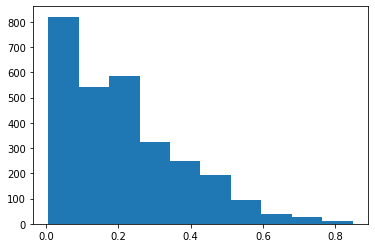

In [50]:
plt.hist(list(nx.degree_centrality(m).values()))
plt.show()

### Nodes with high degree centrality

In [51]:
top_dcm = nodes_with_highest_deg_cent(m)

#### Most popilar movies

In [52]:
print(top_dcm)

{'318M'}


In [53]:
deg_cent_m = nx.degree_centrality(m)

In [54]:
nx.set_node_attributes(m, deg_cent_m, 'degreecentrality')

In [55]:
sorted_deg_cent_m = sorted(deg_cent_m.items(), key=itemgetter(1), reverse=True)

In [56]:
print("Top 10 popular movies:")
for d in sorted_deg_cent_m[:10]:
    print(d,  nx.get_node_attributes(m, 'degreecentrality')[d[0]])

Top 10 popular movies:
('318M', 0.8476454293628809) 0.8476454293628809
('480M', 0.8240997229916898) 0.8240997229916898
('356M', 0.807825484764543) 0.807825484764543
('296M', 0.8005540166204986) 0.8005540166204986
('2858M', 0.7963988919667591) 0.7963988919667591
('110M', 0.7932825484764543) 0.7932825484764543
('593M', 0.7828947368421053) 0.7828947368421053
('1M', 0.7828947368421053) 0.7828947368421053
('1197M', 0.7773545706371191) 0.7773545706371191
('608M', 0.774584487534626) 0.774584487534626


### Distribution of betweenness centrality

In [ ]:
plt.hist(list(nx.betweenness_centrality(m).values()))
plt.show()

### Nodes with hgh betweeness centrality

In [ ]:
top_betm = nodes_with_highest_bet_cent(m)

In [ ]:
print(top_betm)

### Eigenvector Centrality

In [ ]:
eigen_cent_m = nx.eigenvector_centrality(m)

In [ ]:
# Assign each to an attribute in your network
nx.set_node_attributes(m, eigen_cent_m, 'eigenvector')

In [ ]:
sorted_eigenvector_m = sorted(eigen_cent_m.items(), key=itemgetter(1), reverse=True)

In [ ]:
print("Top 10  movie nodes by Eigenvector centrality:")
for e in sorted_eigenvector_m[:10]:
    print(e,  nx.get_node_attributes(m, 'eigenvector')[e[0]])

In [ ]:
largest_clique_m = sorted(nx.find_cliques(m), key=lambda x:len(x))[-1]

In [ ]:
glcm = m.subgraph(largest_clique_m)

In [ ]:
pos = nx.spring_layout(glcm)
betCent = nx.betweenness_centrality(glcm, normalized=True, endpoints=True)
node_color = [20000.0 * glcm.degree(v) for v in glcm]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(10,10))
nx.draw_networkx(glcm, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size)
plt.axis('off')

In [ ]:
[len(c) for c in list(m.subgraph(b) for b in nx.connected_components(m)) if len(c) > 1]